In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

So in the last time we're able to "softly" label ~54% of the dataset based on 2 features which are `male_items` and `female_items`. However, other features might also contribute to the gender, however other features is not clear in a way that we can intepret, we don't even have labels! This is where deep learning shines. 
Later, we will build a representation model on contrastive learning "softly" labeled data. Then use that to predict the other half uncertainty.

For now we're preparing some useful features for the model.

# 1. Load data

In [2]:
with open("clean_data.csv", "r") as f:
    df = pd.read_csv(f)
with open("partial_labels.csv","r") as f:
    partial_labels_df = pd.read_csv(f)

In [3]:
partial_labels_df

,female_flag,customer_id
0,0,3.017372e+09
1,0,3.018459e+09
2,0,3.020737e+09
3,0,3.020872e+09
4,0,3.020897e+09
...,...,...
103805,1,3.706458e+09
103806,1,3.706571e+09
103807,1,3.706577e+09
103808,1,3.706952e+09


In [4]:
# Merge df with label
main_df = pd.merge(df, partial_labels_df, how="right", left_on="customer_id", right_on="customer_id")

# Drop redundant key label after merged
main_df.orders

0          21
1          10
2           8
3           5
4           3
         ... 
103805      8
103806      9
103807     16
103808      3
103809    187
Name: orders, Length: 103810, dtype: int64

In [5]:
main_df.keys()

Index(['days_since_first_order', 'days_since_last_order',
       'is_newsletter_subscriber', 'orders', 'items', 'returns',
       'different_addresses', 'shipping_addresses', 'devices', 'vouchers',
       'cc_payments', 'paypal_payments', 'afterpay_payments', 'female_items',
       'male_items', 'unisex_items', 'wapp_items', 'wftw_items', 'mapp_items',
       'wacc_items', 'macc_items', 'mftw_items', 'sprt_items', 'msite_orders',
       'desktop_orders', 'android_orders', 'ios_orders', 'work_orders',
       'home_orders', 'parcelpoint_orders', 'coupon_discount_applied',
       'revenue', 'customer_id', 'female_flag'],
      dtype='object')

# 2. Feature engineering

Column days_since_first_order
Column days_since_last_order
Column orders
Column items
Column returns


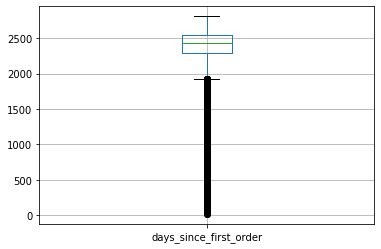

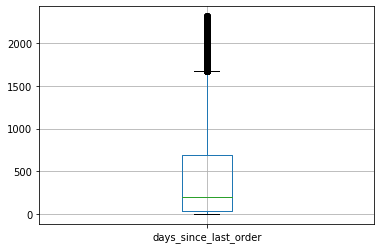

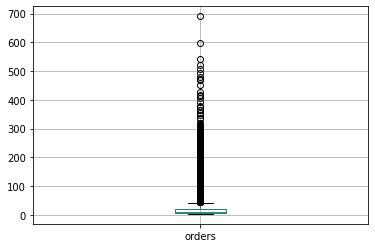

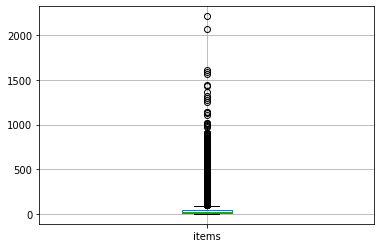

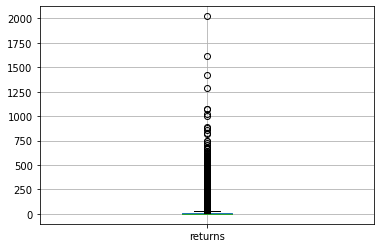

In [6]:
# skip visualize due to categorical object
skip_columns = ['is_newsletter_subscriber','customer_id','female_flag']
top_n = 5
i = 0
for column in main_df:
    if i == top_n:
        break
    elif column in skip_columns:
        continue
    print(f"Column {column}")
    plt.figure()
    main_df.boxplot([column])
    i += 1

From few boxplots we can see that the outliers deviates from the mean a lot. This is due to the nature of accumulative values.

For example:
- returns is accumulative value since because it rises after customer return an order but do not decrease by any mean.
- this kind of feature is not useful because it does not reflect users buying habit. 
- to reflect accurately the user habit we should relate it to the another "time span" variable. For example, returns per order, or returns per items, etc.
    

Here we introduce some features normalized with the "time span" variable (for example `orders` or `items`) to reflect correctly the users behaviors

In [20]:
from utils.data_composer import feature_engineering

In [21]:
main_df = feature_engineering(main_df)
# Get engineered data
engineered_df = main_df.iloc[:,33:]

# Also append column "devices" and "coupon_discount_applied" into
engineered_df = pd.concat([engineered_df, main_df.loc[:,["coupon_discount_applied","devices","customer_id"]]],axis=1)

In [10]:
engineered_df.describe()

,female_flag,items_per_order,vouchers_per_order,male_items_per_order,unisex_items_per_order,female_items_per_order,revenue_per_order,msite_orders_rate,desktop_orders_rate,android_orders_rate,ios_orders_rate,shipping_addresses_rate,home_orders_rate,parcelpoint_orders_rate,work_orders_rate,items_per_day,orders_per_day,returns_per_item,different_addresses_rate,male_items_rate,female_items_rate,unisex_items_rate,wapp_items_rate,wftw_items_rate,mapp_items_rate,wacc_items_rate,macc_items_rate,mftw_items_rate,cc_payments_rate,paypal_payments_rate,afterpay_payments_rate,revenue_per_items,coupon_discount_applied,devices,customer_id
count,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,1.038100e+05
mean,0.852885,2.137805,0.305370,0.370998,0.074927,0.370998,128.136698,0.277079,0.565013,0.017418,0.140490,0.325033,0.515995,0.008111,0.095740,0.022767,0.010352,0.218747,0.053414,0.162008,0.798127,0.039865,0.503633,0.203905,0.094046,0.074136,0.036150,0.049293,0.541054,0.332890,0.106534,63.821084,0.106228,1.972469,3.373555e+09
std,0.354222,1.008227,0.223671,0.840721,0.134899,0.840721,69.475322,0.309759,0.345360,0.087086,0.242613,0.225657,0.329801,0.057139,0.209630,0.074205,0.040196,0.213575,0.137220,0.315440,0.331419,0.078220,0.300835,0.209386,0.214058,0.108045,0.085427,0.124223,0.393980,0.374008,0.225048,28.534945,0.100649,0.725138,2.084696e+08
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.013333,0.000000,0.000000,0.000000,0.000000,0.001848,0.000000,0.000000,0.000000,0.001108,0.001092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.348407,0.000000,1.000000,3.016870e+09
25%,1.000000,1.473684,0.142857,0.000000,0.000000,0.000000,84.970294,0.000000,0.250000,0.000000,0.000000,0.150000,0.250000,0.000000,0.000000,0.005741,0.003218,0.000000,0.000000,0.000000,0.827586,0.000000,0.285714,0.037037,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,44.907381,0.028300,1.000000,3.189497e+09
50%,1.000000,1.916667,0.285714,0.000000,0.000000,0.000000,112.994914,0.166667,0.600000,0.000000,0.000000,0.272727,0.545455,0.000000,0.000000,0.011753,0.005875,0.166667,0.000000,0.000000,0.938910,0.000000,0.574468,0.153846,0.000000,0.035714,0.000000,0.000000,0.571429,0.162162,0.000000,58.777924,0.085100,2.000000,3.376838e+09
75%,1.000000,2.500000,0.444444,0.222222,0.105263,0.222222,151.992458,0.469697,0.891892,0.000000,0.200000,0.444444,0.800000,0.000000,0.032258,0.024381,0.011019,0.348837,0.024096,0.111111,1.000000,0.050000,0.733333,0.290323,0.051282,0.111111,0.031915,0.035088,1.000000,0.666667,0.055556,76.533176,0.157400,2.000000,3.551605e+09
max,1.000000,22.400000,1.000000,16.666667,3.409091,16.666667,1358.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.857143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,498.185000,0.990500,4.000000,3.801194e+09


In [59]:
engineered_df

,female_flag,items_per_order,vouchers_per_order,male_items_per_order,unisex_items_per_order,female_items_per_order,revenue_per_order,msite_orders_rate,desktop_orders_rate,android_orders_rate,ios_orders_rate,shipping_addresses_rate,home_orders_rate,parcelpoint_orders_rate,work_orders_rate,items_per_day,orders_per_day,returns_per_item,different_addresses_rate,male_items_rate,female_items_rate,unisex_items_rate,wapp_items_rate,wftw_items_rate,mapp_items_rate,wacc_items_rate,macc_items_rate,mftw_items_rate,cc_payments_rate,paypal_payments_rate,afterpay_payments_rate,revenue_per_items,coupon_discount_applied,devices,customer_id
0,0,2.761905,0.285714,2.619048,0.142857,2.619048,125.029524,0.095238,0.904762,0.000000,0.000000,0.190476,0.476190,0.0,0.047619,0.021068,0.007628,0.086207,0.017241,0.948276,0.000000,0.051724,0.000000,0.000000,0.706897,0.000000,0.189655,0.086207,0.517241,0.482759,0.000,45.269310,0.0738,2,3.017372e+09
1,0,2.700000,0.400000,2.700000,0.000000,2.700000,138.854000,0.100000,0.900000,0.000000,0.000000,0.400000,0.000000,0.3,0.100000,0.011283,0.004179,0.037037,0.407407,1.000000,0.000000,0.000000,0.000000,0.000000,0.592593,0.000000,0.259259,0.148148,1.000000,0.000000,0.000,51.427407,0.2268,2,3.018459e+09
2,0,1.875000,0.000000,1.625000,0.250000,1.625000,101.880000,0.000000,0.875000,0.000000,0.125000,0.250000,0.500000,0.0,0.000000,0.008255,0.004403,0.000000,0.000000,0.866667,0.000000,0.133333,0.000000,0.000000,0.800000,0.000000,0.066667,0.133333,1.000000,0.000000,0.000,54.336000,0.0012,2,3.020737e+09
3,0,1.800000,0.800000,1.800000,0.000000,1.800000,74.692000,0.000000,1.000000,0.000000,0.000000,0.200000,1.000000,0.0,0.000000,0.004128,0.002294,0.444444,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.888889,0.000000,0.000000,0.111111,1.000000,0.000000,0.000,41.495556,0.4285,1,3.020872e+09
4,0,1.333333,0.000000,1.333333,0.000000,1.333333,180.860000,0.000000,1.000000,0.000000,0.000000,0.333333,1.000000,0.0,0.000000,0.002411,0.001808,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.750000,0.000000,1.000000,0.000,135.645000,0.0018,1,3.020897e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103805,1,1.500000,0.000000,0.250000,0.000000,0.250000,71.933750,0.250000,0.750000,0.000000,0.000000,0.125000,1.000000,0.0,0.000000,0.005602,0.003735,0.333333,0.000000,0.166667,0.833333,0.000000,0.583333,0.166667,0.000000,0.083333,0.166667,0.000000,1.000000,0.000000,0.000,47.955833,0.0017,3,3.706458e+09
103806,1,2.000000,0.222222,0.222222,0.222222,0.222222,183.125556,0.666667,0.333333,0.000000,0.000000,0.666667,0.666667,0.0,0.222222,0.008982,0.004491,0.111111,0.000000,0.111111,0.777778,0.111111,0.444444,0.222222,0.000000,0.222222,0.000000,0.000000,0.444444,0.555556,0.000,91.562778,0.0411,2,3.706571e+09
103807,1,2.500000,0.250000,0.125000,0.250000,0.125000,157.228125,0.125000,0.125000,0.000000,0.750000,0.187500,0.875000,0.0,0.000000,0.018174,0.007269,0.100000,0.000000,0.050000,0.850000,0.100000,0.375000,0.200000,0.025000,0.250000,0.025000,0.075000,0.075000,0.000000,0.900,62.891250,0.0471,3,3.706577e+09
103808,1,2.666667,0.000000,0.333333,0.000000,0.333333,147.496667,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333,0.0,0.000000,0.004042,0.001516,0.000000,0.375000,0.125000,0.875000,0.000000,0.250000,0.500000,0.000000,0.125000,0.000000,0.000000,0.000000,0.875000,0.125,55.311250,0.0022,1,3.706952e+09


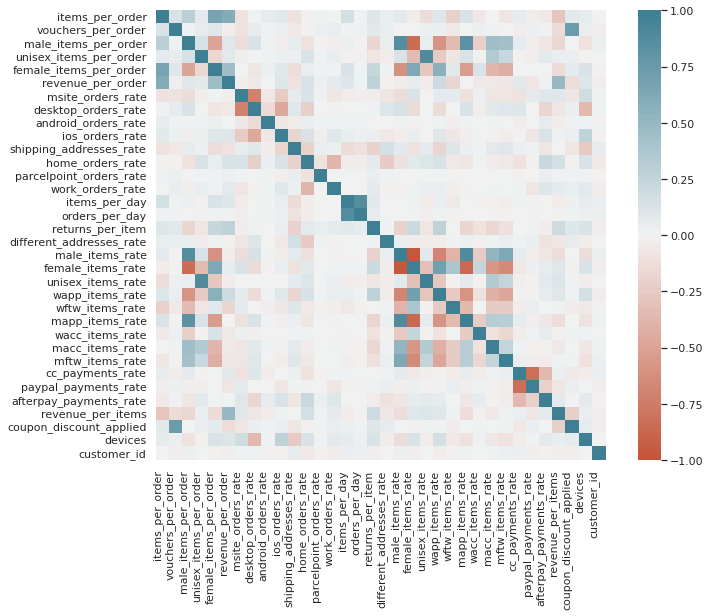

In [22]:
# df_ = df.copy()
# df_ = df_.drop(["days_since_first_order","customer_id","days_since_last_order"], axis=1)
sns.set(rc={'figure.figsize':(11.7,8.27)})

corr = engineered_df.drop("female_flag",axis=1).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [57]:

c = corr

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False, key=lambda value: value.abs())
so.head(20)

# Remove self correlated
for index in so.index:
    if index[0] == index[1]:
        so.drop(index,inplace=True)
        
# Remove duplicate pair
already_paired = []

for index in so.index:
    if index[0] == index[1]:
        so.drop(index,inplace=True)
    elif (index[1], index[0]) in already_paired:
        so.drop(index, inplace=True)
    already_paired.append(index)

In [58]:
so.head(32)

male_items_per_order     female_items_per_order    1.000000
female_items_rate        male_items_rate          -0.971958
unisex_items_per_order   unisex_items_rate         0.894411
male_items_rate          mapp_items_rate           0.888208
orders_per_day           items_per_day             0.874034
male_items_rate          female_items_per_order    0.872799
                         male_items_per_order      0.872799
female_items_rate        mapp_items_rate          -0.861088
female_items_per_order   female_items_rate        -0.841106
male_items_per_order     female_items_rate        -0.841106
                         mapp_items_rate           0.835203
mapp_items_rate          female_items_per_order    0.835203
cc_payments_rate         paypal_payments_rate     -0.821014
coupon_discount_applied  vouchers_per_order        0.738546
female_items_rate        wapp_items_rate           0.711299
msite_orders_rate        desktop_orders_rate      -0.708304
male_items_rate          wapp_items_rate

In [33]:
s.sort_values(kind="quicksort", ascending=False)

customer_id               customer_id                 1.000000
mapp_items_rate           mapp_items_rate             1.000000
different_addresses_rate  different_addresses_rate    1.000000
male_items_rate           male_items_rate             1.000000
female_items_rate         female_items_rate           1.000000
                                                        ...   
items_per_day             work_orders_rate            0.000768
paypal_payments_rate      parcelpoint_orders_rate     0.000709
parcelpoint_orders_rate   paypal_payments_rate        0.000709
                          orders_per_day              0.000115
orders_per_day            parcelpoint_orders_rate     0.000115
Length: 1225, dtype: float64

In [36]:
s.index[0]

('female_flag', 'female_flag')

Okay so we have most data scaled between 0 and 1. That's a great signal. For other column, outlier might be a problem. But no worry, we will use RobustScaler to scale it down without being suffered from largely deviated outliers.

In [23]:
engineered_df.to_csv("modeling_data.csv",index=False)